In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statistics 
import pickle
from sklearn import linear_model
from scipy.optimize import minimize

Parameter estimation problem: A data is generated by the SDE
$$dX = \mu Xdt + \sigma dW, \qquad \text{where} \mu = -1, \sigma = 1$$.
Here, the diffusion is just constant


In [371]:

with open('data_simple.pickle', 'rb') as f:
    [Xt,X_avg,t]= pickle.load(f)





In [434]:
N = len(Xt)
X0 = Xt[0]

N_data = 100
Xt_reduce = Xt[:N_data]
T_reduce = t[N_data]

dt = t[1]-t[0]
T = t[-1]


In [373]:
mu_tr = -1
sigma_tr = 1

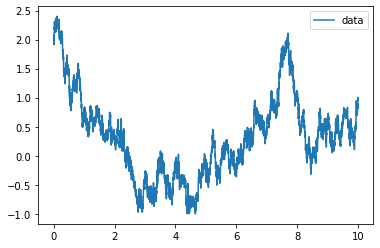

In [374]:
# plot the data
plt.plot(t,Xt)

plt.legend(['data','avg'],)
plt.show()

In [375]:
def loss(para,Xt,dt):
    
    mu,sigma = para
    dX = (Xt[1:]-Xt[:-1])
    N = len(dX)-1
    
    
    drift_loss = np.sum((dX/dt - mu*Xt[:-1])**2)/N
    
    diff_loss = np.sum(((dX-dt*mu*Xt[:-1])**2/dt - sigma**2)**2)/N
   
   
    
    return drift_loss + diff_loss
    

In [376]:
def loss_grad(para,Xt,dt):
    mu,sigma = para
    dX = (Xt[1:]-Xt[:-1])
    N = len(dX)-1
    
    
    J1_mu = -np.dot(2*(dX/dt - mu*Xt[:-1]), Xt[:-1])/N
    J2_mu = np.dot(np.multiply(-4*((dX-dt*mu*Xt[:-1])**2/dt - sigma**2), (dX-dt*mu*Xt[:-1])),Xt[:-1])/N
    J2_sigma = -4*sigma/N*np.sum(((dX-dt*mu*Xt[:-1])**2/dt - sigma**2))
    
    grad_mu = J1_mu+J2_mu
    
    return grad_mu, J2_sigma
    

In [378]:
def gradient_descent(gradient, ini, learn_rate, n_iter,Xt,dt):
    # stochastic gradient optimizers
    Mu =[]
    Sig = []
    vec_mu, vec_sig = ini
    for _ in range(n_iter):
        grad_mu, grad_sig = gradient((vec_mu,vec_sig),Xt,dt)
        vec_mu = vec_mu -learn_rate*grad_mu
        vec_sig = vec_sig-learn_rate*grad_sig
        
        Mu.append(vec_mu)
        Sig.append(vec_sig)
    return vec_mu, vec_sig,Mu, Sig
    


In [390]:
def print_loss(Mu,Sig):
    Loss =[]
    for i in range(len(Mu)):
        mu_i = Mu[i]
        sig_i = Sig[i]

        Loss.append(loss((mu_i, sig_i),Xt,dt))
    
    return Loss

In [396]:
def f_learned(mu, sigma,X0,t,dt):
    X_lr = []
    X_tr = []
    
    X_lr.append(X0)
    X_tr.append(X0)
    
                          
    for i in range(len(t)-1):    
        x_lr = X_lr[-1]
        x_tr = X_tr[-1]
        
        
        sigma_tr = 1
        mu_tr = -1
        
        dW = np.random.normal(0,np.sqrt(dt),1)
        
        x_lr = x_lr + mu*x_lr*dt + sigma*dW
        x_tr = x_tr + mu_tr*x_tr*dt + sigma_tr*dW
        
        X_lr.append(x_lr)
        X_tr.append(x_tr)
        
    
    return X_lr, X_tr

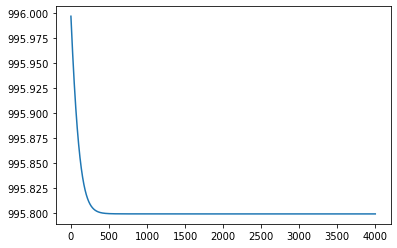

In [398]:
# plot the histories of the training loss
Loss = print_loss(Mu,Sig)
plt.plot(Loss)

In [399]:
#initialize the parameters
para_ini = (np.random.normal(0,1), np.abs( np.random.normal(0,1)))
print('initial:', para_ini)
opt_mu, opt_sig, Mu, Sig = gradient_descent(loss_grad, para_ini, 0.001,4000,Xt,dt)
print('optimal:', opt_mu, opt_sig)
print('true:' ,mu_tr, sigma_tr)

initial: (-0.8770941765936955, 0.4956583224345049)
optimal: -1.0613654877547287 0.9968678375719945
true: -1 1


In [401]:
X_lr, X_tr = f_learned(opt_mu, opt_sig,X0,t,dt)


/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


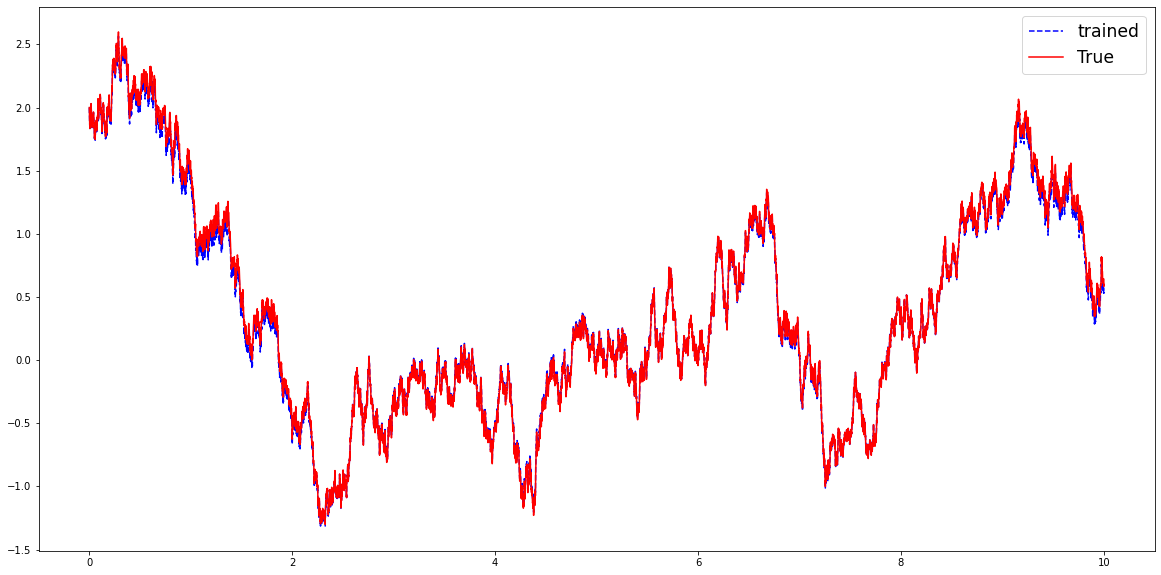

In [403]:
# plot the trajectories with true/optimal parameters
plt.figure(figsize=(20, 10))
plt.plot(t,X_lr,'b--',label='trained')
plt.plot(t,X_tr ,'r',label='True')

plt.legend(fontsize = 'xx-large')
plt.show()

In [404]:
with open('data_simple_linear.pickle', 'rb') as f:
    [Xt,t]= pickle.load(f)



In [405]:
N = len(Xt)
X0 = Xt[0]


dt = t[1]-t[0]
T = t[-1]
print(T,N,dt)

20.0 20000 0.001000050002500125



Parameter estimation problem: A data is generated by the SDE
$$dX = \mu Xdt + \sigma X dW\qquad \mu = 0.2,\sigma = 0.1$$
Here, we have linear drift and linear diffusion. 

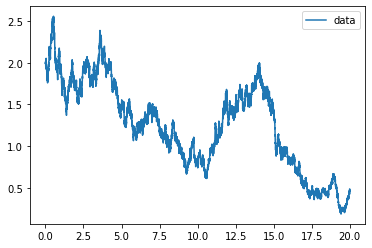

In [438]:
# plot the data
plt.plot(t,Xt)

plt.legend(['data','avg'],)
plt.show()



In [416]:
def loss_linear_sig(para,Xt,dt):
    # variance is parameter, not sigma
    mu,var = para
    dX = (Xt[1:]-Xt[:-1])
    N = len(dX)-1
    
    
    drift_loss = np.sum((dX/dt - mu*Xt[:-1])**2)/N
    
    diff_loss = np.sum(((dX-dt*mu*Xt[:-1])**2/dt - var*Xt[:-1]**2)**2)/N
    
    
    return drift_loss + diff_loss

In [417]:
def loss_grad_linear_sig(para,Xt,dt):
    mu,var = para
    dX = (Xt[1:]-Xt[:-1])
    N = len(dX)-1
    
    
    J1_mu = -np.dot(2*(dX/dt - mu*Xt[:-1]), Xt[:-1])/N
    
    
    J2_mu = np.dot(np.multiply(-4*((dX-dt*mu*Xt[:-1])**2/dt -var*Xt[:-1]**2), (dX-dt*mu*Xt[:-1])),Xt[:-1])/N
    J2_sigma = -2/N*np.dot(((dX-dt*mu*Xt[:-1])**2/dt - var*Xt[:-1]**2), Xt[:-1]**2)
    
    grad_mu = J1_mu+J2_mu
    
    return grad_mu, J2_sigma
    

In [425]:
def f_learned(mu, sigma,X0,t,dt):
    X_lr = []
    X_tr = []
    
    X_lr.append(X0)
    X_tr.append(X0)
    
                          
    for i in range(len(t)-1):    
        x_lr = X_lr[-1]
        x_tr = X_tr[-1]
        
        mu_tr = 0.2
        sigma_tr = 0.1

        dW = np.random.normal(0,np.sqrt(dt),1)
        
        x_lr = x_lr + mu*x_lr*dt + sigma*x_lr*dW
        x_tr = x_tr + mu_tr*x_tr*dt + sigma_tr*x_tr*dW
        
        X_lr.append(x_lr)
        X_tr.append(x_tr)
        
    
    return X_lr, X_tr

In [423]:
para_ini = (np.random.normal(0,1), np.abs( np.random.normal(0,1)))
N_tr =5000
Xt_reduce = Xt[:N_tr]
opt_mu, opt_var, Mu, Var = gradient_descent(loss_grad_linear_sig, para_ini,0.001,4000, Xt_reduce,dt)
print('optimal:' ,opt_mu,np.sqrt(opt_var))
mu_tr = 0.2
sigma_tr = 0.1
print('true:', mu_tr, sigma_tr)

optimal: 0.20625702018394126 0.09773401308262461
true: 0.2 0.1


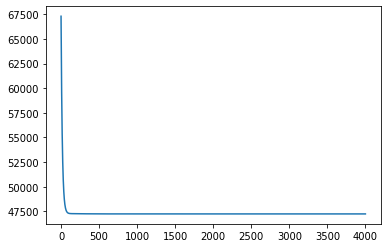

In [426]:
Loss = print_loss(Mu,Sig)
plt.plot(Loss)

In [429]:
X_lr, X_tr = f_learned(opt_mu,np.sqrt(opt_var),X0,t,dt)


-1.0647108419407982 0.9872806127350575


/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


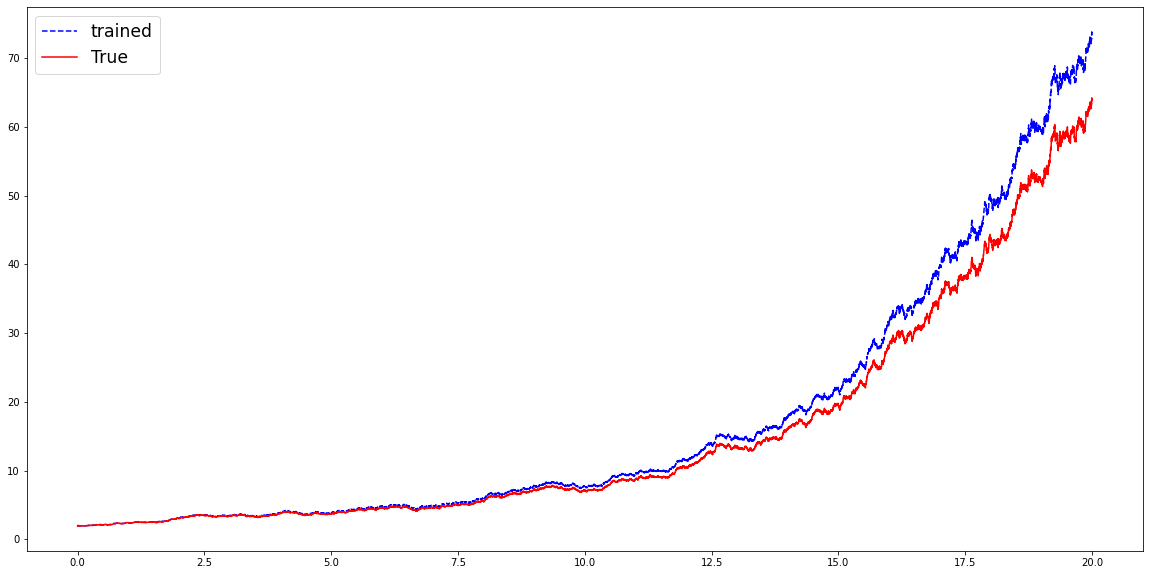

In [430]:

plt.figure(figsize=(20, 10))
plt.plot(t,X_lr,'b--',label='trained')
plt.plot(t,X_tr ,'r',label='True')

plt.legend(fontsize = 'xx-large')
plt.show()

/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


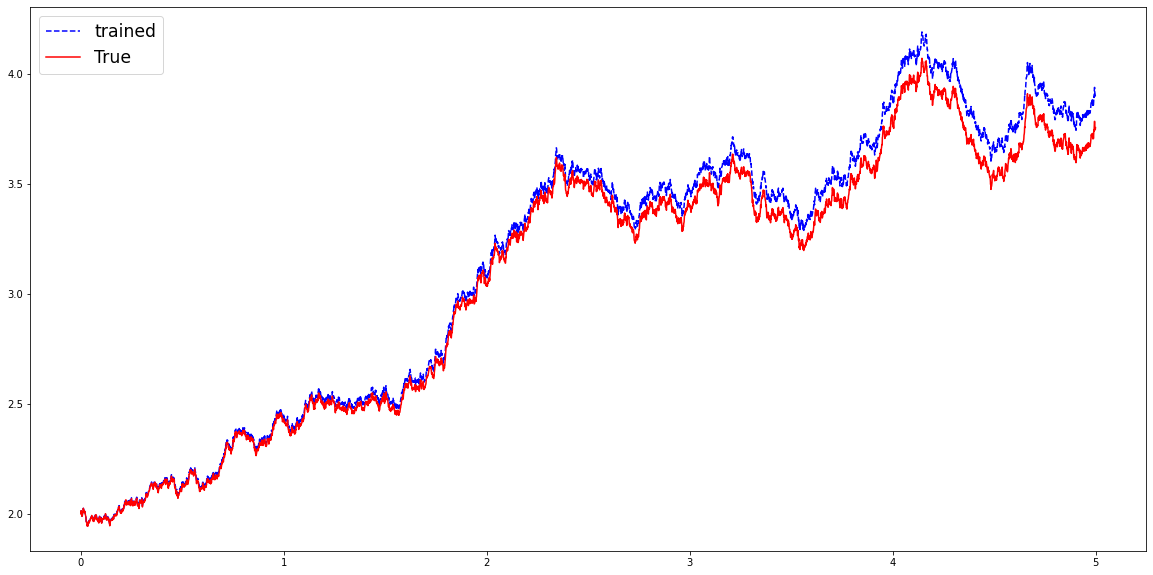

In [432]:
# truncate time interval upto T = 5
plt.figure(figsize=(20, 10))
plt.plot(t[:N_tr],X_lr[:N_tr],'b--',label='trained')
plt.plot(t[:N_tr],X_tr[:N_tr] ,'r',label='True')

plt.legend(fontsize = 'xx-large')
plt.show()

In [433]:
with open('data_simple_CLE.pickle', 'rb') as f:
    [Xt,t]= pickle.load(f)



Parameter estimation problem: A data is generated by the Langevin equation form
$$dX = -\mu Xdt - \sqrt{\mu X} dW\qquad \mu = 0.1,$$
that is the diffusion is sqrt(drift).

In [435]:
N = len(Xt)
X0 = Xt[0]


dt = t[1]-t[0]
T = t[-1]
print(N,T)

20000 20.0


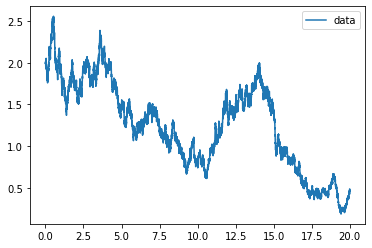

In [437]:
# plot the data
plt.plot(t,Xt)

plt.legend(['data','avg'],)
plt.show()


In [439]:
def loss_cle(mu,Xt,dt):
    
   
    dX = (Xt[1:]-Xt[:-1])
    N = len(dX)-1
    
    
    drift_loss = np.sum((dX/dt + mu*Xt[:-1])**2)/N
    
    diff_loss = np.sum(((dX - dt*mu*Xt[:-1])**2/dt - mu*Xt[:-1])**2)/N
    
    
   
   
    
    return drift_loss + diff_loss
    

In [440]:
def loss_grad_cle(para,Xt,dt):
    mu= para
    dX = (Xt[1:]-Xt[:-1])
    N = len(dX)-1
    
    
    J1_mu = np.dot(2*(dX/dt + mu*Xt[:-1]), Xt[:-1])/N
    det_mu = 2*np.multiply(dX -dt*mu*Xt[:-1], Xt[:-1]) -Xt[:-1]
    J2_mu = 2*np.dot((dX - dt*mu*Xt[:-1])**2/dt - mu*Xt[:-1], det_mu)/N
    
    
    grad_mu = J1_mu+J2_mu
    
    return grad_mu
    

In [441]:
def gradient_descent_one(gradient, ini, learn_rate, n_iter,Xt,dt):
    Mu =[]
 
    vec_mu = ini
    for _ in range(n_iter):
        grad_mu= gradient(vec_mu,Xt,dt)
        vec_mu = vec_mu -learn_rate*grad_mu
        
        Mu.append(vec_mu)
       
    return vec_mu,Mu
    

In [320]:
def print_loss_one(Mu):
    Loss =[]
    for i in range(len(Mu)):
        mu_i = Mu[i]
        

        Loss.append(loss_cle((mu_i),Xt,dt))
    
    return Loss

In [447]:
def f_learned(mu,X0,t,dt):
    X_lr = []
    X_tr = []
    
    X_lr.append(X0)
    X_tr.append(X0)
    
                          
    for i in range(len(t)-1):    
        x_lr = X_lr[-1]
        x_tr = X_tr[-1]
        
        
 
        mu_tr = 0.1
        
        dW = np.random.normal(0,np.sqrt(dt),1)
        
        x_lr = x_lr - mu*x_lr*dt  -np.sqrt(mu*x_lr)*dW
        x_tr = x_tr - mu_tr*x_tr*dt -np.sqrt(mu_tr*x_tr)*dW
        
        X_lr.append(x_lr)
        X_tr.append(x_tr)
        
        
    
    return X_lr, X_tr

In [451]:
mu_ini =  np.abs( np.random.normal(0,1))
opt_mu, Mu = gradient_descent_one(loss_grad_cle, mu_ini,0.001,4000, Xt,dt)
mu_tr = 0.1
print('optimal:',opt_mu)
print('true:',mu_tr)

optimal: 0.09255101160630272
true: 0.1


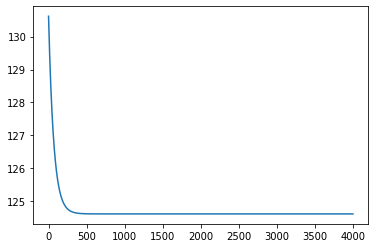

In [452]:
Loss = print_loss_one(Mu)
plt.plot(Loss)

In [456]:
X_lr, X_tr = f_learned(opt_mu,X0,t,dt)


/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
/Users/rkyoon/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


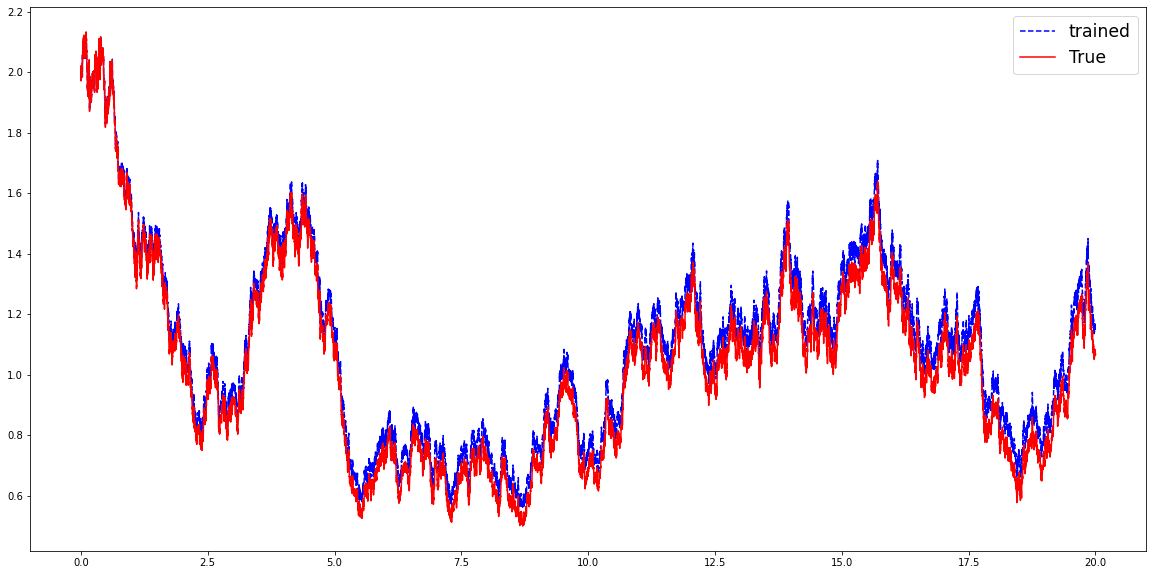

In [457]:

plt.figure(figsize=(20, 10))
plt.plot(t,X_lr,'b--',label='trained')
plt.plot(t,X_tr ,'r',label='True')

plt.legend(fontsize = 'xx-large')
plt.show()